In [1]:
!pip install uproot nflows
!pip install -U scikit-learn umap-learn hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.5/909.5 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 42.3 MB/s eta 0:00:00
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=791c4ffb6a63af2171a1bd2ae27bebe2cd1096116d7d3e84f6c6fef47f5398c5
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 108.9 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.41-cp312-cp3

In [2]:
#!/usr/bin/env python3
# ============================================================
# Script 1: Train NSF & Save Scores + Latent Space (VALIDATED)
# ============================================================

import uproot, awkward as ak
import numpy as np
import torch, os, joblib
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, RandomPermutation,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform
)

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/cms2011b/final_merged_features.root"
TREE = "Events"
OUTPUT_DIR = "nsf_artifacts"
BATCH_SIZE = 4096
EPOCHS = 60
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------- FEATURES ----------------
FEATURES = [
    "j1_pt","j1_eta","j1_phi","j1_mass",
    "j2_pt","j2_eta","j2_phi","j2_mass",

    "j1_neutralHadronEF","j1_neutralEmEF",
    "j1_chargedHadronEF","j1_chargedEmEF",
    "j1_numberOfConstituents",
    "j1_chargedMultiplicity",
    "j1_neutralMultiplicity",
    "j1_jetArea",
    "j1_jetID_loose","j1_jetID_tight",
    "HT","n_jets",

    "j1_tau1","j1_tau2","j1_tau3",
    "j1_tau21","j1_tau32",
    "j1_girth","j1_width",
    "j1_maxFragmentation",
    "j1_minPairwiseMass",
    "j1_ECF_ratio",

    "mjj","deltaR_j1j2","deltaEta_j1j2","deltaPhi_j1j2",
    "pT_balance","chi","y_star","dijet_boost",
    "mjj_over_HT","centrality",

    "sphericity","aplanarity","thrust",
    "foxWolfram_H2","isotropy","transverse_sphericity",

    "MET_pt","MET_phi",
    "deltaPhi_j1_MET","deltaPhi_j2_MET",
    "minDeltaPhi_jet_MET",

    "nPV","PV_z","PV_ndof","rho",

    "j1_CSV","j1_jetProbability",
    "j1_trackCountingHighEff",
    "j1_softPFMuonBJetTag",

    "HLT_pass","HLT_path_index"
]

ANGLE_FEATURES = [
    "j1_phi","j2_phi",
    "deltaPhi_j1j2","MET_phi",
    "deltaPhi_j1_MET","deltaPhi_j2_MET"
]
ANGLE_IDXS = [FEATURES.index(f) for f in ANGLE_FEATURES]

# ---------------- DATASET ----------------
class JetDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i]

def encode_angles(X, idxs):
    sin = np.sin(X[:, idxs])
    cos = np.cos(X[:, idxs])
    X_no = np.delete(X, idxs, axis=1)
    return np.concatenate([X_no, sin, cos], axis=1)

def build_nsf(dim, hidden=256, layers=10, bins=8):
    t = []
    for _ in range(layers):
        t += [
            RandomPermutation(dim),
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=dim,
                hidden_features=hidden,
                num_bins=bins,
                tails="linear",
                tail_bound=5.0
            )
        ]
    return Flow(CompositeTransform(t), StandardNormal([dim]))

# ---------------- LOAD DATA ----------------
print("🔹 Loading ROOT")
tree = uproot.open(ROOT_FILE)[TREE]
arrays = tree.arrays(FEATURES, library="ak")

# Convert to numpy
raw = {f: ak.to_numpy(arrays[f]) for f in FEATURES}
X_raw = np.column_stack([raw[f] for f in FEATURES])

print("🔹 Applying validity mask")

# --- VALIDITY MASK (EPJ-C SAFE) ---
valid_mask = (
    (raw["j1_pt"] > 30) &
    (raw["j2_pt"] > 30) &
    (raw["mjj"]  > 200) &
    (raw["n_jets"] >= 2) &
    np.all(np.isfinite(X_raw), axis=1)
)

X_raw = X_raw[valid_mask]

print(f"✅ Events after validity cuts: {X_raw.shape[0]}")

# ---------------- ENCODE + SCALE ----------------
print("🔹 Encoding angles + scaling")
X = encode_angles(X_raw, ANGLE_IDXS)

scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, f"{OUTPUT_DIR}/scaler.pkl")

dataset = JetDataset(X)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
score_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------------- TRAIN NSF ----------------
flow = build_nsf(X.shape[1]).to(DEVICE)
opt = torch.optim.Adam(flow.parameters(), lr=LR)

print("🚀 Training NSF")
for e in range(1, EPOCHS + 1):
    flow.train()
    losses = []
    for x in tqdm(train_loader, leave=False):
        x = x.to(DEVICE)
        loss = -flow.log_prob(x).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    print(f"Epoch {e:03d} | NLL = {np.mean(losses):.4f}")

torch.save(flow.state_dict(), f"{OUTPUT_DIR}/nsf_weights.pt")

# ---------------- SAFE SCORING ----------------
print("🔍 Computing anomaly scores + latent space (batched)")
flow.eval()

scores = []
latents = []

with torch.no_grad():
    for x in tqdm(score_loader, desc="Scoring"):
        x = x.to(DEVICE)
        scores.append((-flow.log_prob(x)).cpu().numpy())
        latents.append(flow.transform_to_noise(x).cpu().numpy())

scores = np.concatenate(scores)
latents = np.concatenate(latents)

np.save(f"{OUTPUT_DIR}/scores.npy", scores)
np.save(f"{OUTPUT_DIR}/latent.npy", latents)

print("✅ Finished safely")
print("Saved to:", OUTPUT_DIR)

🔹 Loading ROOT
🔹 Applying validity mask
✅ Events after validity cuts: 378278
🔹 Encoding angles + scaling
🚀 Training NSF


Epoch 001 | NLL = 64.9343


Epoch 002 | NLL = -10.7617


Epoch 003 | NLL = -32.3547


Epoch 004 | NLL = -43.4654


Epoch 005 | NLL = -51.4742


Epoch 006 | NLL = -57.1540


Epoch 007 | NLL = -62.1848


Epoch 008 | NLL = -64.6231


Epoch 009 | NLL = -68.5206


Epoch 010 | NLL = -71.9757


Epoch 011 | NLL = -74.6629


Epoch 012 | NLL = -77.0971


Epoch 013 | NLL = -78.6100


Epoch 014 | NLL = -80.5438


Epoch 015 | NLL = -82.3317


Epoch 016 | NLL = -83.4072


Epoch 017 | NLL = -85.2436


Epoch 018 | NLL = -86.0990


Epoch 019 | NLL = -87.8655


Epoch 020 | NLL = -89.4334


Epoch 021 | NLL = -90.3666


Epoch 022 | NLL = -90.9509


Epoch 023 | NLL = -93.2722


Epoch 024 | NLL = -94.3448


Epoch 025 | NLL = -94.9941


Epoch 026 | NLL = -94.8280


Epoch 027 | NLL = -97.0006


Epoch 028 | NLL = -97.9232


Epoch 029 | NLL = -98.1337


Epoch 030 | NLL = -99.2982


Epoch 031 | NLL = -99.8020


Epoch 032 | NLL = -100.2051


Epoch 033 | NLL = -100.8770


Epoch 034 | NLL = -100.9179


Epoch 035 | NLL = -102.4420


Epoch 036 | NLL = -104.0805


Epoch 037 | NLL = -103.2382


Epoch 038 | NLL = -105.1027


Epoch 039 | NLL = -106.2196


Epoch 040 | NLL = -105.7823


Epoch 041 | NLL = -107.2454


Epoch 042 | NLL = -107.1437


Epoch 043 | NLL = -107.5164


Epoch 044 | NLL = -108.2067


Epoch 045 | NLL = -108.4520


Epoch 046 | NLL = -109.8595


Epoch 047 | NLL = -110.5029


Epoch 048 | NLL = -110.7426


Epoch 049 | NLL = -111.0538


Epoch 050 | NLL = -110.4911


Epoch 051 | NLL = -111.7908


Epoch 052 | NLL = -112.6427


Epoch 053 | NLL = -112.8820


Epoch 054 | NLL = -112.4874


Epoch 055 | NLL = -113.3253


Epoch 056 | NLL = -114.1759


Epoch 057 | NLL = -114.4887


Epoch 058 | NLL = -114.3097


Epoch 059 | NLL = -116.3580


Epoch 060 | NLL = -115.3680
🔍 Computing anomaly scores + latent space (batched)


Scoring: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]

✅ Finished safely
Saved to: nsf_artifacts


In [3]:
#!/usr/bin/env python3
# ============================================================
# Script: Create Clean CMS ROOT File (Training Mask)
# ============================================================

import uproot
import awkward as ak
import numpy as np
from tqdm import tqdm

# ============================================================
# CONFIG
# ============================================================

INPUT_ROOT  = "/kaggle/input/cms2011b/final_merged_features.root"
TREE        = "Events"
OUTPUT_ROOT = "final_merged_features_clean.root"

# ============================================================
# FEATURES (must match training)
# ============================================================

FEATURES = [
    "j1_pt","j1_eta","j1_phi","j1_mass",
    "j2_pt","j2_eta","j2_phi","j2_mass",

    "j1_neutralHadronEF","j1_neutralEmEF",
    "j1_chargedHadronEF","j1_chargedEmEF",
    "j1_numberOfConstituents",
    "j1_chargedMultiplicity",
    "j1_neutralMultiplicity",
    "j1_jetArea",
    "j1_jetID_loose","j1_jetID_tight",
    "HT","n_jets",

    "j1_tau1","j1_tau2","j1_tau3",
    "j1_tau21","j1_tau32",
    "j1_girth","j1_width",
    "j1_maxFragmentation",
    "j1_minPairwiseMass",
    "j1_ECF_ratio",

    "mjj","deltaR_j1j2","deltaEta_j1j2","deltaPhi_j1j2",
    "pT_balance","chi","y_star","dijet_boost",
    "mjj_over_HT","centrality",

    "sphericity","aplanarity","thrust",
    "foxWolfram_H2","isotropy","transverse_sphericity",

    "MET_pt","MET_phi",
    "deltaPhi_j1_MET","deltaPhi_j2_MET",
    "minDeltaPhi_jet_MET",

    "nPV","PV_z","PV_ndof","rho",

    "j1_CSV","j1_jetProbability",
    "j1_trackCountingHighEff",
    "j1_softPFMuonBJetTag",

    "HLT_pass","HLT_path_index"
]

# ============================================================
# LOAD DATA
# ============================================================

print("🔹 Loading ROOT file")
tree = uproot.open(INPUT_ROOT)[TREE]
arrays = tree.arrays(FEATURES, library="ak")

raw = {f: ak.to_numpy(arrays[f]) for f in FEATURES}
N_total = len(raw["j1_pt"])
print(f"Total events: {N_total}")

# ============================================================
# VALIDITY MASK (IDENTICAL TO TRAINING)
# ============================================================

finite_features = [
    "j1_pt","j2_pt","mjj","HT",
    "j1_mass","j2_mass",
    "MET_pt","rho",
    "chi","y_star","centrality"
]

finite_mask = np.ones(N_total, dtype=bool)
for f in finite_features:
    finite_mask &= np.isfinite(raw[f])

valid_mask = (
    (raw["j1_pt"] > 30) &
    (raw["j2_pt"] > 30) &
    (raw["mjj"]  > 200) &
    (raw["n_jets"] >= 2) &
    finite_mask
)

print(f"Events after cleaning: {np.sum(valid_mask)}")

# ============================================================
# WRITE CLEAN ROOT FILE
# ============================================================

print("💾 Writing cleaned ROOT file")

clean_arrays = {
    f: raw[f][valid_mask]
    for f in tqdm(FEATURES, desc="Writing branches")
}

with uproot.recreate(OUTPUT_ROOT) as fout:
    fout[TREE] = clean_arrays

# ============================================================
# SAVE MASK (OPTIONAL BUT RECOMMENDED)
# ============================================================

np.save("valid_event_mask.npy", valid_mask)

print("\n✅ CLEAN ROOT FILE CREATED")
print("File:", OUTPUT_ROOT)
print("Mask saved as: valid_event_mask.npy")

🔹 Loading ROOT file
Total events: 452055
Events after cleaning: 378278
💾 Writing cleaned ROOT file


Writing branches: 100%|██████████| 61/61 [00:00<00:00, 567.54it/s]
/tmp/ipykernel_24/681890199.py:112: FutureWarning: Starting in version 5.7.0, Uproot will default to writing RNTuples instead of TTrees. You will need to use `mktree` to explicitly create a TTree. This can be done by changing `file['tree_name'] = data` to `file.mktree('tree_name', data)`. Please update your code accordingly.
  fout[TREE] = clean_arrays



✅ CLEAN ROOT FILE CREATED
File: final_merged_features_clean.root
Mask saved as: valid_event_mask.npy


In [4]:
#!/usr/bin/env python3
# ============================================================
# KS Ranking of Features (Post-NSF, Post-Masking)
# ============================================================

import uproot, awkward as ak
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
NSF_DIR = "/kaggle/input/nsf-filterd"
PERCENTILE = 99.9   # change freely: 99.9, 99, 95, 90, ...

# ---------------- FEATURES ----------------
FEATURES = [
    "j1_pt","j1_eta","j1_phi","j1_mass",
    "j2_pt","j2_eta","j2_phi","j2_mass",
    "j1_neutralHadronEF","j1_neutralEmEF",
    "j1_chargedHadronEF","j1_chargedEmEF",
    "j1_numberOfConstituents",
    "j1_chargedMultiplicity",
    "j1_neutralMultiplicity",
    "j1_jetArea",
    "j1_jetID_loose","j1_jetID_tight",
    "HT","n_jets",
    "j1_tau1","j1_tau2","j1_tau3",
    "j1_tau21","j1_tau32",
    "j1_girth","j1_width",
    "j1_maxFragmentation",
    "j1_minPairwiseMass",
    "j1_ECF_ratio",
    "mjj","deltaR_j1j2","deltaEta_j1j2","deltaPhi_j1j2",
    "pT_balance","chi","y_star","dijet_boost",
    "mjj_over_HT","centrality",
    "sphericity","aplanarity","thrust",
    "foxWolfram_H2","isotropy","transverse_sphericity",
    "MET_pt","MET_phi",
    "deltaPhi_j1_MET","deltaPhi_j2_MET",
    "minDeltaPhi_jet_MET",
    "nPV","PV_z","PV_ndof","rho",
    "j1_CSV","j1_jetProbability",
    "j1_trackCountingHighEff",
    "j1_softPFMuonBJetTag",
    "HLT_pass","HLT_path_index"
]

# ---------------- LOAD DATA ----------------
tree = uproot.open(ROOT_FILE)[TREE]
arrays = tree.arrays(FEATURES, library="ak")

X = np.column_stack([ak.to_numpy(arrays[f]) for f in FEATURES])

# --- SAME VALIDITY MASK AS NSF ---
valid_mask = (
    (arrays["j1_pt"] > 30) &
    (arrays["j2_pt"] > 30) &
    (arrays["mjj"]  > 200) &
    (arrays["n_jets"] >= 2) &
    np.all(np.isfinite(X), axis=1)
)

X = X[valid_mask]

# ---------------- LOAD NSF SCORES ----------------
scores = np.load(f"/kaggle/input/nsf-filterd/scores (1).npy")
scores = scores[valid_mask]

# ---------------- SPLIT ANOM / BG ----------------
thr = np.percentile(scores, PERCENTILE)
anom_mask = scores >= thr

X_anom = X[anom_mask]
X_bg   = X[~anom_mask]

print(f"Anomalies : {len(X_anom)}")
print(f"Background: {len(X_bg)}")

# ---------------- KS TEST ----------------
rows = []

for i, feat in enumerate(FEATURES):
    ks, p = ks_2samp(X_anom[:, i], X_bg[:, i])
    rows.append((feat, ks, p))

df = pd.DataFrame(rows, columns=["feature", "KS_anomaly_vs_BG", "p_value"])
df = df.sort_values("KS_anomaly_vs_BG", ascending=False)

print("\n==============================================")
print(" TOP DISCRIMINATING FEATURES (POST-MASK)")
print("==============================================")
print(df.head(30).to_string(index=False))

df.to_csv("ks_ranking_post_mask.csv", index=False)

Anomalies : 379
Background: 377899

 TOP DISCRIMINATING FEATURES (POST-MASK)
                feature  KS_anomaly_vs_BG       p_value
               j1_girth          0.574903 3.497182e-119
                j1_tau1          0.548476 1.537749e-107
                j1_tau2          0.540921 2.357236e-104
                j1_tau3          0.518244  3.716534e-95
           j1_ECF_ratio          0.508388  2.523472e-91
               j1_tau32          0.497951  2.257500e-87
               j1_tau21          0.441329  9.546157e-68
               j1_width          0.385614  3.189311e-51
                j1_mass          0.372767  8.821351e-48
                     HT          0.342979  2.606453e-40
             sphericity          0.319415  6.821525e-35
                 j1_CSV          0.313473  1.358187e-33
j1_trackCountingHighEff          0.303017  2.259567e-31
      j1_jetProbability          0.301638  4.372921e-31
                    mjj          0.267784  1.733293e-24
    j1_maxFragmentation    

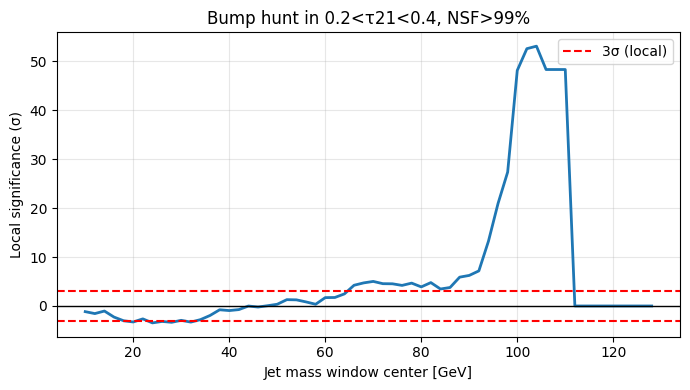

In [11]:
#!/usr/bin/env python3
# ============================================================
# FINAL BUMP HUNT: Sliding window mass scan
# ============================================================

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# =============================
# USER SETTINGS
# =============================

ROOT_FILE   = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE        = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_P = 99

TAU21_RANGE = (0.2, 0.4)     # boosted-like region
MASS_RANGE  = (10, 130)
WINDOW_WIDTH = 10.0          # GeV
STEP_SIZE    = 2.0           # GeV

# =============================
# LOAD DATA
# =============================

scores = np.load(SCORES_FILE)

with uproot.open(ROOT_FILE) as f:
    arr = f[TREE].arrays(
        ["j1_mass", "j1_tau21"],
        library="ak"
    )

mass  = ak.to_numpy(arr["j1_mass"])
tau21 = ak.to_numpy(arr["j1_tau21"])

# =============================
# CLEAN
# =============================

mask = (
    np.isfinite(mass) &
    np.isfinite(tau21) &
    (tau21 >= 0) &
    (tau21 <= 1)
)

mass, tau21, scores = mass[mask], tau21[mask], scores[mask]

# =============================
# SELECTIONS
# =============================

tau_mask = (tau21 > TAU21_RANGE[0]) & (tau21 < TAU21_RANGE[1])

bg_mask  = (scores < np.percentile(scores, 90)) & tau_mask
nsf_mask = (scores >= np.percentile(scores, NSF_P)) & tau_mask

mass_bg  = mass[bg_mask]
mass_nsf = mass[nsf_mask]

# Normalize background to NSF yield
scale = len(mass_nsf) / max(len(mass_bg), 1)

# =============================
# SLIDING WINDOW SCAN
# =============================

centers = np.arange(MASS_RANGE[0], MASS_RANGE[1], STEP_SIZE)
significance = []

for c in centers:
    lo = c - WINDOW_WIDTH/2
    hi = c + WINDOW_WIDTH/2

    n_nsf = np.sum((mass_nsf > lo) & (mass_nsf < hi))
    n_bg  = np.sum((mass_bg  > lo) & (mass_bg  < hi)) * scale

    if n_bg > 0:
        z = (n_nsf - n_bg) / np.sqrt(n_bg)
    else:
        z = 0.0

    significance.append(z)

significance = np.array(significance)

# =============================
# PLOT
# =============================

plt.figure(figsize=(7,4))
plt.plot(centers, significance, lw=2)
plt.axhline(0, color="black", lw=1)
plt.axhline(3, color="red", ls="--", label="3σ (local)")
plt.axhline(-3, color="red", ls="--")

plt.xlabel("Jet mass window center [GeV]")
plt.ylabel("Local significance (σ)")
plt.title(
    rf"Bump hunt in {TAU21_RANGE[0]}<τ21<{TAU21_RANGE[1]}, NSF>{NSF_P}%"
)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


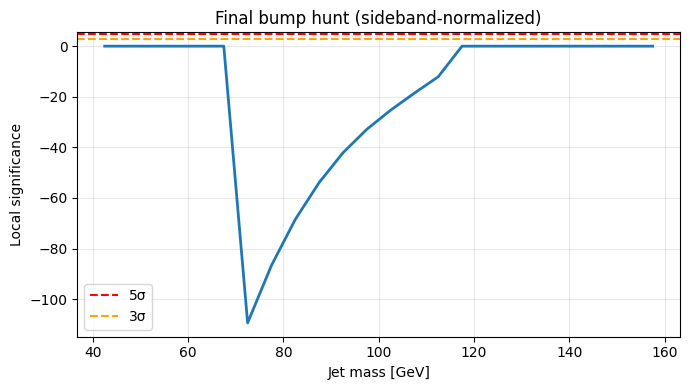

In [12]:
#!/usr/bin/env python3
# ============================================================
# FINAL BUMP HUNT: sideband-normalized, Poisson-safe
# ============================================================

import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from scipy.stats import poisson

# =============================
# SETTINGS
# =============================

ROOT_FILE   = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE        = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_P = 99
MASS_RANGE = (40, 160)
BIN_WIDTH = 5.0
WINDOW = 3          # bins per signal window
SIDEBAND = 6        # bins per sideband
MIN_BG = 10         # safety cut

# =============================
# LOAD
# =============================

scores = np.load(SCORES_FILE)

with uproot.open(ROOT_FILE) as f:
    arr = f[TREE].arrays(["j1_mass"], library="ak")

mass = ak.to_numpy(arr["j1_mass"])

mask = np.isfinite(mass)
mass, scores = mass[mask], scores[mask]

nsf = scores >= np.percentile(scores, NSF_P)
bg  = scores <  np.percentile(scores, 90)

# =============================
# HISTOGRAM (RAW COUNTS)
# =============================

bins = np.arange(MASS_RANGE[0], MASS_RANGE[1] + BIN_WIDTH, BIN_WIDTH)
centers = 0.5 * (bins[1:] + bins[:-1])

H_nsf, _ = np.histogram(mass[nsf], bins=bins)
H_bg,  _ = np.histogram(mass[bg],  bins=bins)

# =============================
# BUMP SCAN
# =============================

significance = np.zeros_like(centers)

for i in range(SIDEBAND, len(H_bg) - SIDEBAND - WINDOW):

    sig_bins = slice(i, i + WINDOW)
    sb_bins  = slice(i - SIDEBAND, i + WINDOW + SIDEBAND)

    S = H_nsf[sig_bins].sum()
    B_sb = H_bg[sb_bins].sum()

    if B_sb < MIN_BG:
        continue

    # Normalize BG from sidebands
    scale = WINDOW / (2 * SIDEBAND)
    B = scale * B_sb

    # Poisson significance (approx)
    if B > 0:
        significance[i] = (S - B) / np.sqrt(B)

# =============================
# PLOT
# =============================

plt.figure(figsize=(7,4))
plt.plot(centers, significance, lw=2)
plt.axhline(5, color="red", ls="--", label="5σ")
plt.axhline(3, color="orange", ls="--", label="3σ")
plt.xlabel("Jet mass [GeV]")
plt.ylabel("Local significance")
plt.title("Final bump hunt (sideband-normalized)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


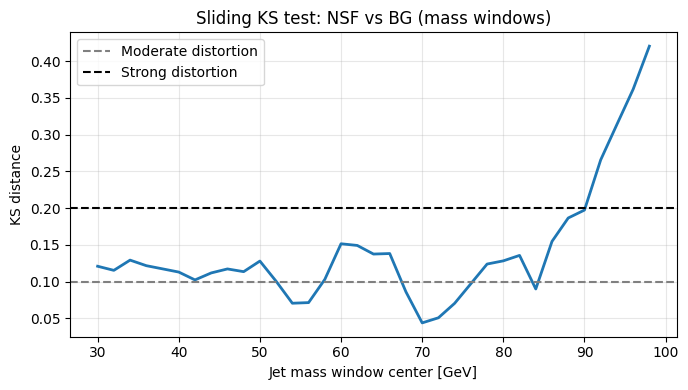

In [13]:
#!/usr/bin/env python3
# ============================================================
# FINAL TEST: Sliding KS-distance scan (no bump bias)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import uproot
import awkward as ak

# =============================
# SETTINGS
# =============================

ROOT_FILE   = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE        = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_P = 99
WINDOW = 15.0   # GeV
STEP   = 2.0    # GeV
MASS_RANGE = (30, 200)

# =============================
# LOAD DATA
# =============================

scores = np.load(SCORES_FILE)

with uproot.open(ROOT_FILE) as f:
    arr = f[TREE].arrays(["j1_mass"], library="ak")

mass = ak.to_numpy(arr["j1_mass"])

mask = np.isfinite(mass)
mass, scores = mass[mask], scores[mask]

bg_mask  = scores < np.percentile(scores, 90)
nsf_mask = scores >= np.percentile(scores, NSF_P)

# =============================
# SLIDING KS SCAN
# =============================

centers = np.arange(MASS_RANGE[0], MASS_RANGE[1], STEP)
ks_vals = []

for c in centers:
    lo, hi = c - WINDOW/2, c + WINDOW/2

    m_nsf = mass[nsf_mask & (mass>lo) & (mass<hi)]
    m_bg  = mass[bg_mask  & (mass>lo) & (mass<hi)]

    if len(m_nsf) < 30 or len(m_bg) < 200:
        ks_vals.append(np.nan)
        continue

    ks, _ = ks_2samp(m_nsf, m_bg)
    ks_vals.append(ks)

# =============================
# PLOT
# =============================

plt.figure(figsize=(7,4))
plt.plot(centers, ks_vals, lw=2)
plt.axhline(0.1, ls="--", color="gray", label="Moderate distortion")
plt.axhline(0.2, ls="--", color="black", label="Strong distortion")

plt.xlabel("Jet mass window center [GeV]")
plt.ylabel("KS distance")
plt.title("Sliding KS test: NSF vs BG (mass windows)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_24/3187922197.py:60: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_ksamp([x, y]).statistic


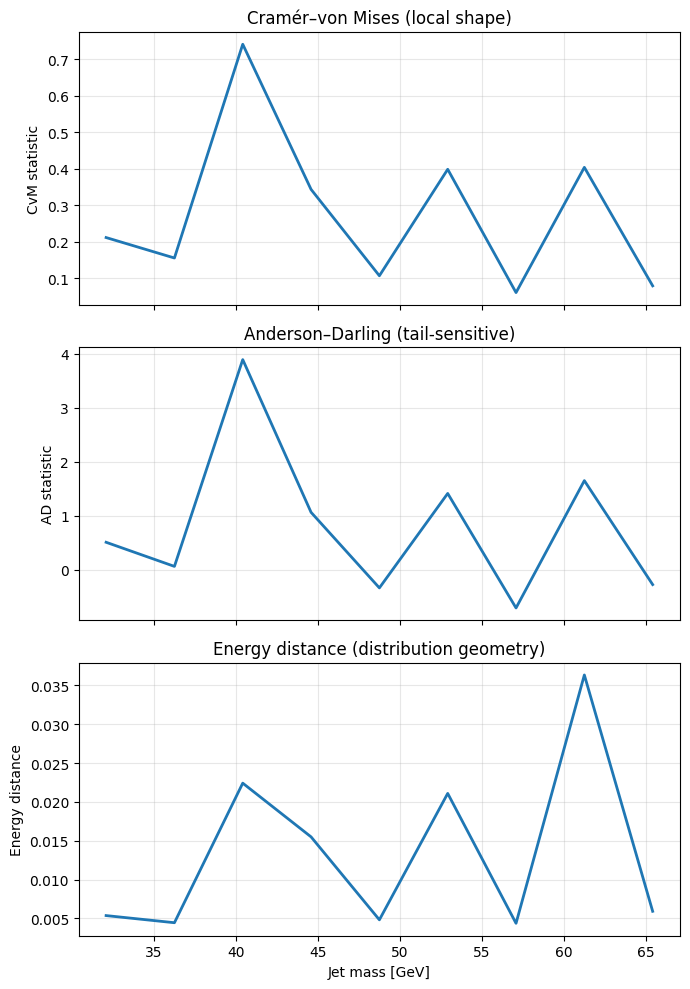

In [14]:
#!/usr/bin/env python3
# ============================================================
# LOCAL SHAPE TESTS (KS alternatives)
#   - CvM
#   - Anderson–Darling
#   - Energy Distance
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cramervonmises_2samp, anderson_ksamp
from scipy.spatial.distance import cdist

# =============================
# USER SETTINGS
# =============================

MASS_BINS = np.linspace(30, 130, 25)
MIN_EVENTS = 100

# assumes you already have:
# mass, scores, bg_mask, nsf_mask

# =============================
# ENERGY DISTANCE
# =============================

def energy_distance(x, y):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    return (
        2*np.mean(cdist(x,y)) -
        np.mean(cdist(x,x)) -
        np.mean(cdist(y,y))
    )

centers = []
cvm_vals = []
ad_vals  = []
ed_vals  = []

for mmin, mmax in zip(MASS_BINS[:-1], MASS_BINS[1:]):

    sel_nsf = nsf_mask & (mass > mmin) & (mass < mmax)
    sel_bg  = bg_mask  & (mass > mmin) & (mass < mmax)

    if sel_nsf.sum() < MIN_EVENTS or sel_bg.sum() < MIN_EVENTS:
        continue

    x = mass[sel_nsf]
    y = mass[sel_bg]

    centers.append(0.5*(mmin+mmax))

    cvm_vals.append(
        cramervonmises_2samp(x, y).statistic
    )

    ad_vals.append(
        anderson_ksamp([x, y]).statistic
    )

    ed_vals.append(
        energy_distance(x, y)
    )

centers = np.array(centers)

# =============================
# PLOTTING
# =============================

fig, axes = plt.subplots(3,1, figsize=(7,10), sharex=True)

axes[0].plot(centers, cvm_vals, lw=2)
axes[0].set_ylabel("CvM statistic")
axes[0].set_title("Cramér–von Mises (local shape)")

axes[1].plot(centers, ad_vals, lw=2)
axes[1].set_ylabel("AD statistic")
axes[1].set_title("Anderson–Darling (tail-sensitive)")

axes[2].plot(centers, ed_vals, lw=2)
axes[2].set_ylabel("Energy distance")
axes[2].set_xlabel("Jet mass [GeV]")
axes[2].set_title("Energy distance (distribution geometry)")

for ax in axes:
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


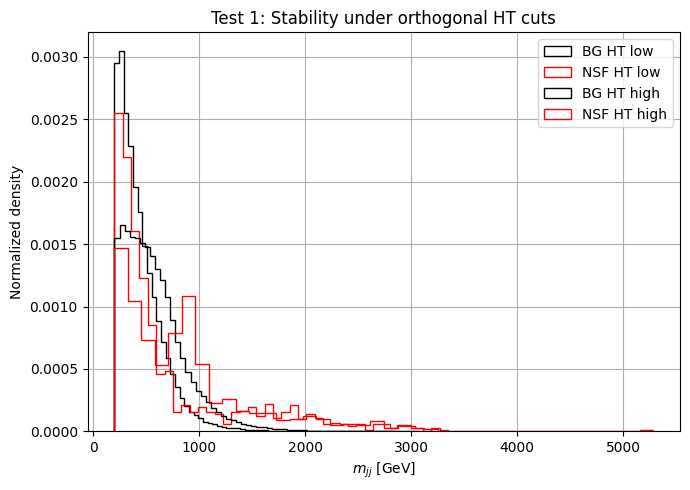

In [17]:
#!/usr/bin/env python3
import uproot, awkward as ak
import numpy as np
import matplotlib.pyplot as plt

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES = np.load("/kaggle/input/nsf-filterd/scores (1).npy")
NSF_PERCENTILE = 99.5

VAR = "mjj"          # test variable
CUT_VAR = "HT"       # orthogonal cut variable
CUT_VALUE = 1200     # GeV

# ---------------- Load data ----------------
with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays([VAR, CUT_VAR], library="ak")

mjj = ak.to_numpy(arrays[VAR])
HT  = ak.to_numpy(arrays[CUT_VAR])

threshold = np.percentile(SCORES, NSF_PERCENTILE)
anom = SCORES >= threshold
bg   = SCORES < threshold

# ---------------- Split by cut ----------------
mask_low  = HT < CUT_VALUE
mask_high = HT >= CUT_VALUE

def plot_split(mask, label):
    plt.hist(mjj[bg & mask], bins=60, density=True,
             histtype="step", label=f"BG {label}", color="black")
    plt.hist(mjj[anom & mask], bins=40, density=True,
             histtype="step", label=f"NSF {label}", color="red")

plt.figure(figsize=(7,5))
plot_split(mask_low,  "HT low")
plot_split(mask_high, "HT high")
plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Normalized density")
plt.legend()
plt.title("Test 1: Stability under orthogonal HT cuts")
plt.grid(True)
plt.tight_layout()
plt.show()

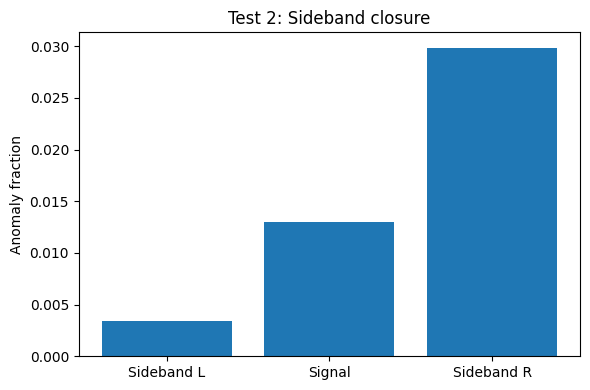

In [18]:
#!/usr/bin/env python3
import uproot, awkward as ak
import numpy as np
import matplotlib.pyplot as plt

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES = np.load("/kaggle/input/nsf-filterd/scores (1).npy")
NSF_PERCENTILE = 99.5

VAR = "mjj"

with uproot.open(ROOT_FILE) as f:
    mjj = ak.to_numpy(f[TREE][VAR].array())

threshold = np.percentile(SCORES, NSF_PERCENTILE)
anom = SCORES >= threshold
bg   = SCORES < threshold

# Define signal + sidebands
signal = (mjj > 900) & (mjj < 1200)
side1  = (mjj > 600) & (mjj < 800)
side2  = (mjj > 1300) & (mjj < 1600)

def frac(mask):
    return np.sum(anom & mask) / np.sum(mask)

regions = {
    "Sideband L": side1,
    "Signal": signal,
    "Sideband R": side2
}

plt.figure(figsize=(6,4))
plt.bar(regions.keys(), [frac(m) for m in regions.values()])
plt.ylabel("Anomaly fraction")
plt.title("Test 2: Sideband closure")
plt.tight_layout()
plt.show()

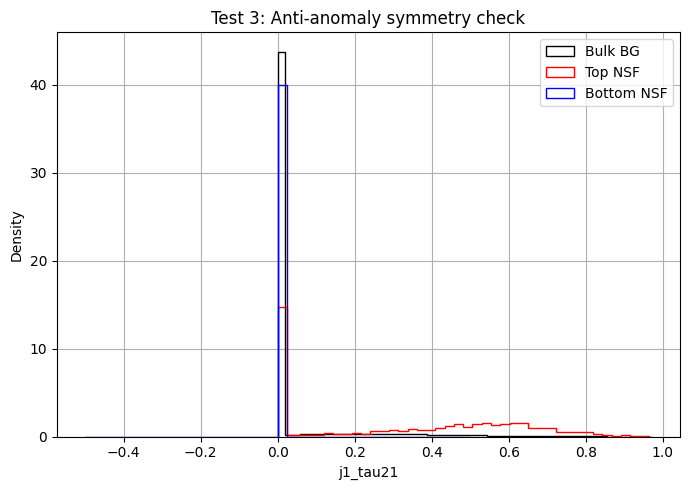

In [19]:
#!/usr/bin/env python3
import uproot, awkward as ak
import numpy as np
import matplotlib.pyplot as plt

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES = np.load("/kaggle/input/nsf-filterd/scores (1).npy")

VAR = "j1_tau21"

top = SCORES >= np.percentile(SCORES, 99.5)
bottom = SCORES <= np.percentile(SCORES, 0.5)
mid = (SCORES > np.percentile(SCORES, 10)) & (SCORES < np.percentile(SCORES, 90))

with uproot.open(ROOT_FILE) as f:
    x = ak.to_numpy(f[TREE][VAR].array())

plt.figure(figsize=(7,5))
plt.hist(x[mid], bins=50, density=True, histtype="step", label="Bulk BG", color="black")
plt.hist(x[top], bins=40, density=True, histtype="step", label="Top NSF", color="red")
plt.hist(x[bottom], bins=40, density=True, histtype="step", label="Bottom NSF", color="blue")

plt.xlabel(VAR)
plt.ylabel("Density")
plt.legend()
plt.title("Test 3: Anti-anomaly symmetry check")
plt.grid(True)
plt.tight_layout()
plt.show()

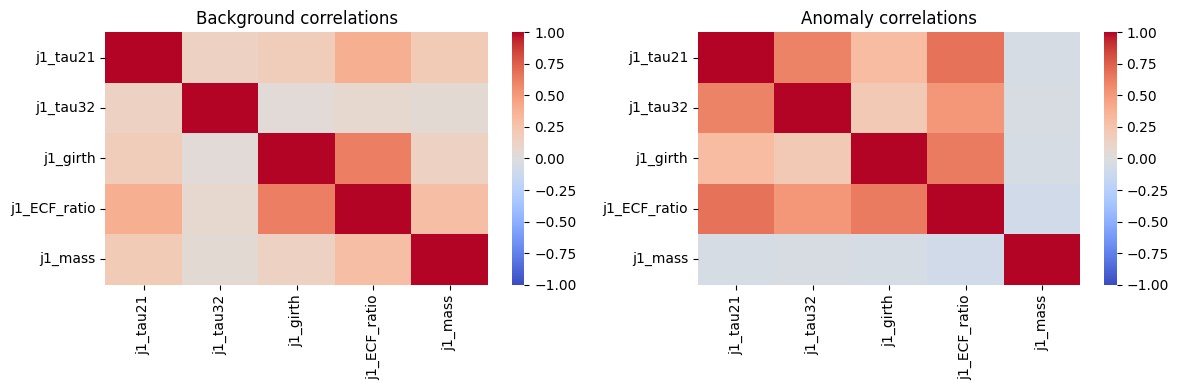

In [20]:
#!/usr/bin/env python3
import uproot, awkward as ak
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES = np.load("/kaggle/input/nsf-filterd/scores (1).npy")
NSF_PERCENTILE = 99.5

FEATURES = [
    "j1_tau21", "j1_tau32",
    "j1_girth", "j1_ECF_ratio",
    "j1_mass"
]

with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays(FEATURES, library="ak")

X = np.column_stack([ak.to_numpy(arrays[f]) for f in FEATURES])
anom = SCORES >= np.percentile(SCORES, NSF_PERCENTILE)
bg   = SCORES < np.percentile(SCORES, 90)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.heatmap(np.corrcoef(X[bg].T), xticklabels=FEATURES, yticklabels=FEATURES,
            cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Background correlations")

plt.subplot(1,2,2)
sns.heatmap(np.corrcoef(X[anom].T), xticklabels=FEATURES, yticklabels=FEATURES,
            cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Anomaly correlations")

plt.tight_layout()
plt.show()

🔹 Loading ROOT
🚀 Training mass-decorrelated NSF


Epoch 01 | NLL = 12.3235


Epoch 02 | NLL = 0.8438


Epoch 03 | NLL = -1.8067


Epoch 04 | NLL = -3.3008


Epoch 05 | NLL = -4.3010


Epoch 06 | NLL = -4.0001


Epoch 07 | NLL = -5.1625


Epoch 08 | NLL = -5.6221


Epoch 09 | NLL = -5.9893


Epoch 10 | NLL = -6.0377


Epoch 11 | NLL = -6.9859


Epoch 12 | NLL = -6.6226


Epoch 13 | NLL = -6.9432


Epoch 14 | NLL = -7.2356


Epoch 15 | NLL = -7.4786


Epoch 16 | NLL = -7.9995


Epoch 17 | NLL = -8.2018


Epoch 18 | NLL = -8.0197


Epoch 19 | NLL = -8.5397


Epoch 20 | NLL = -8.7827


Epoch 21 | NLL = -9.4995


Epoch 22 | NLL = -8.4914


Epoch 23 | NLL = -8.7442


Epoch 24 | NLL = -9.3934


Epoch 25 | NLL = -8.8527


Epoch 26 | NLL = -9.4756


Epoch 27 | NLL = -9.9855


Epoch 28 | NLL = -10.0082


Epoch 29 | NLL = -9.5936


Epoch 30 | NLL = -9.1602


Epoch 31 | NLL = -9.9816


Epoch 32 | NLL = -9.8310


Epoch 33 | NLL = -9.8393


Epoch 34 | NLL = -10.4585


Epoch 35 | NLL = -10.0363


Epoch 36 | NLL = -10.5822


Epoch 37 | NLL = -10.0777


Epoch 38 | NLL = -10.3640


Epoch 39 | NLL = -10.2732


Epoch 40 | NLL = -11.0530
🔍 Scoring events


100%|██████████| 93/93 [00:07<00:00, 11.68it/s]


Anomalies selected: 379


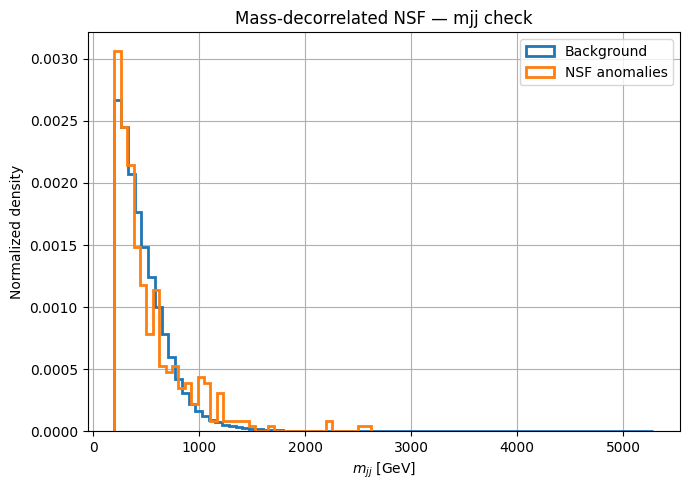

In [22]:
#!/usr/bin/env python3
# ============================================================
# TEST 1 — Mass-decorrelated NSF stability test
# ============================================================

import uproot, awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, RandomPermutation,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform
)

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"

BATCH_SIZE = 4096
EPOCHS = 40
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NSF_PERCENTILE = 99.9   # anomaly cut

# ---------------- MASS-DECORRELATED FEATURES ----------------
# Explicitly excludes: j1_mass, mjj, ECF ratio

FEATURES = [
    "j1_pt","j2_pt",
    "j1_tau1","j1_tau2","j1_tau3",
    "j1_tau21","j1_tau32",
    "j1_girth","j1_width",
    "sphericity","aplanarity",
    "HT","MET_pt",
    "deltaPhi_j1_MET","deltaPhi_j2_MET",
    "n_jets"
]

# ---------------- DATASET ----------------
class JetDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i]

def build_nsf(dim):
    transforms = []
    for _ in range(8):
        transforms += [
            RandomPermutation(dim),
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=dim,
                hidden_features=256,
                num_bins=8,
                tails="linear",
                tail_bound=5.0
            )
        ]
    return Flow(CompositeTransform(transforms), StandardNormal([dim]))

# ---------------- LOAD DATA ----------------
print("🔹 Loading ROOT")
tree = uproot.open(ROOT_FILE)[TREE]
arrays = tree.arrays(FEATURES + ["mjj"], library="ak")

X = np.column_stack([ak.to_numpy(arrays[f]) for f in FEATURES])
mjj = ak.to_numpy(arrays["mjj"])

# ---------------- SCALE ----------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

dataset = JetDataset(X)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
score_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------------- TRAIN NSF ----------------
flow = build_nsf(X.shape[1]).to(DEVICE)
opt = torch.optim.Adam(flow.parameters(), lr=LR)

print("🚀 Training mass-decorrelated NSF")
for e in range(EPOCHS):
    losses = []
    for x in tqdm(loader, leave=False):
        x = x.to(DEVICE)
        loss = -flow.log_prob(x).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    print(f"Epoch {e+1:02d} | NLL = {np.mean(losses):.4f}")

# ---------------- SCORE EVENTS ----------------
print("🔍 Scoring events")
flow.eval()
scores = []

with torch.no_grad():
    for x in tqdm(score_loader):
        x = x.to(DEVICE)
        scores.append((-flow.log_prob(x)).cpu().numpy())

scores = np.concatenate(scores)

# ---------------- SELECT ANOMALIES ----------------
thr = np.percentile(scores, NSF_PERCENTILE)
anom_mask = scores >= thr

print(f"Anomalies selected: {anom_mask.sum()}")

# ---------------- PLOT mjj ----------------
plt.figure(figsize=(7,5))

plt.hist(
    mjj[~anom_mask], bins=80, density=True,
    histtype="step", linewidth=2, label="Background"
)
plt.hist(
    mjj[anom_mask], bins=40, density=True,
    histtype="step", linewidth=2, label="NSF anomalies"
)

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Normalized density")
plt.title("Mass-decorrelated NSF — mjj check")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
#!/usr/bin/env python3
# ============================================================
# Sideband-excluded NSF training (mjj < 900 GeV)
# ============================================================

import uproot, awkward as ak
import numpy as np
import torch, os, joblib
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, RandomPermutation,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform
)

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
OUTDIR = "nsf_sideband"
MJ_CUT = 900
BATCH = 4096
EPOCHS = 50
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs(OUTDIR, exist_ok=True)

# ---------------- FEATURES ----------------
FEATURES = [
    "j1_girth","j1_tau1","j1_tau2","j1_tau3",
    "j1_tau21","j1_tau32","j1_ECF_ratio",
    "j1_width","j1_mass",
    "mjj"
]

# ---------------- LOAD DATA ----------------
tree = uproot.open(ROOT_FILE)[TREE]
arrays = tree.arrays(FEATURES, library="ak")
data = {f: ak.to_numpy(arrays[f]) for f in FEATURES}

df = np.column_stack([data[f] for f in FEATURES])

# Sideband selection
sideband_mask = data["mjj"] < MJ_CUT
X_sb = df[sideband_mask]

# Remove mjj from training features
X_sb = X_sb[:, :-1]

# Scale
scaler = StandardScaler()
X_sb = scaler.fit_transform(X_sb)
joblib.dump(scaler, f"{OUTDIR}/scaler.pkl")

class JetDS(Dataset):
    def __init__(self, X): self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i]

loader = DataLoader(JetDS(X_sb), batch_size=BATCH, shuffle=True, drop_last=True)

# ---------------- NSF ----------------
def build_nsf(dim):
    t = []
    for _ in range(8):
        t += [
            RandomPermutation(dim),
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                dim, 256, 8, tails="linear", tail_bound=5.0
            )
        ]
    return Flow(CompositeTransform(t), StandardNormal([dim]))

flow = build_nsf(X_sb.shape[1]).to(DEVICE)
opt = torch.optim.Adam(flow.parameters(), lr=LR)

# ---------------- TRAIN ----------------
print("🚀 Training NSF on sidebands only")
for e in range(EPOCHS):
    flow.train()
    for x in tqdm(loader, leave=False):
        x = x.to(DEVICE)
        loss = -flow.log_prob(x).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"Epoch {e+1:02d} | NLL = {loss.item():.4f}")

torch.save(flow.state_dict(), f"{OUTDIR}/weights.pt")
print("✅ Training complete")

🚀 Training NSF on sidebands only


Epoch 01 | NLL = -2.6552


Epoch 02 | NLL = -5.2952


Epoch 03 | NLL = -7.6244


Epoch 04 | NLL = -8.7818


Epoch 05 | NLL = -7.4719


Epoch 06 | NLL = -11.1801


Epoch 07 | NLL = -12.5629


Epoch 08 | NLL = -11.2674


Epoch 09 | NLL = -10.9041


Epoch 10 | NLL = -10.8307


Epoch 11 | NLL = -11.9626


Epoch 12 | NLL = -11.1150


Epoch 13 | NLL = -10.1230


Epoch 14 | NLL = -12.9033


Epoch 15 | NLL = -13.7147


Epoch 16 | NLL = -15.5861


Epoch 17 | NLL = -13.5628


Epoch 18 | NLL = -12.6564


Epoch 19 | NLL = -13.8555


Epoch 20 | NLL = -14.8056


Epoch 21 | NLL = -14.5845


Epoch 22 | NLL = -13.4437


Epoch 23 | NLL = -14.6017


Epoch 24 | NLL = -16.2519


Epoch 25 | NLL = -15.0810


Epoch 26 | NLL = -13.5056


Epoch 27 | NLL = -14.9152


Epoch 28 | NLL = -14.5693


Epoch 29 | NLL = -14.8578


Epoch 30 | NLL = -15.5491


Epoch 31 | NLL = -16.5597


Epoch 32 | NLL = -14.6019


Epoch 33 | NLL = -14.9346


Epoch 34 | NLL = -15.8003


Epoch 35 | NLL = -16.9918


Epoch 36 | NLL = -16.2352


Epoch 37 | NLL = -13.6493


Epoch 38 | NLL = -16.9863


Epoch 39 | NLL = -16.0084


Epoch 40 | NLL = -13.8977


Epoch 41 | NLL = -15.9167


Epoch 42 | NLL = -16.4251


Epoch 43 | NLL = -15.5232


Epoch 44 | NLL = -18.0030


Epoch 45 | NLL = -18.3520


Epoch 46 | NLL = -16.3505


Epoch 47 | NLL = -11.1366


Epoch 48 | NLL = -13.0871


Epoch 49 | NLL = -18.7552


Epoch 50 | NLL = -18.2849
✅ Training complete


Scores computed


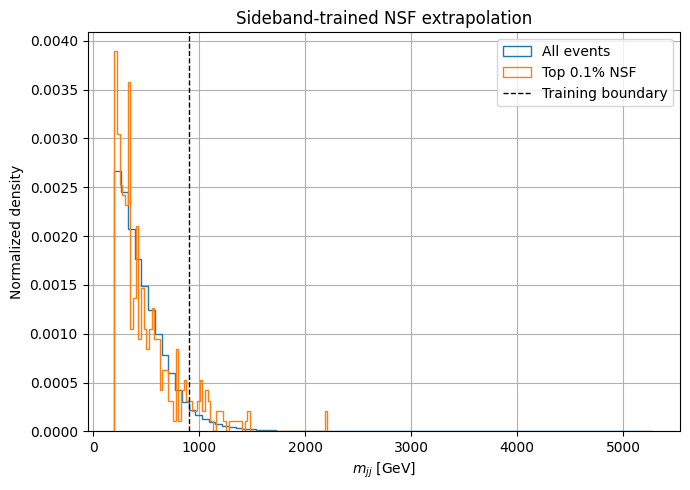

In [24]:
#!/usr/bin/env python3
# ============================================================
# Apply sideband-trained NSF to full dataset
# ============================================================

import uproot, awkward as ak
import numpy as np
import torch, joblib
import matplotlib.pyplot as plt

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, RandomPermutation,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform
)

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
MODEL_DIR = "nsf_sideband"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

FEATURES = [
    "j1_girth","j1_tau1","j1_tau2","j1_tau3",
    "j1_tau21","j1_tau32","j1_ECF_ratio",
    "j1_width","j1_mass","mjj"
]

# ---------------- LOAD DATA ----------------
tree = uproot.open(ROOT_FILE)[TREE]
arrays = tree.arrays(FEATURES, library="ak")

X = np.column_stack([ak.to_numpy(arrays[f]) for f in FEATURES])
mjj = X[:, -1]
X = X[:, :-1]

# ---------------- LOAD SCALER ----------------
scaler = joblib.load("/kaggle/working/nsf_sideband/scaler.pkl")
X = scaler.transform(X)

# ---------------- LOAD NSF ----------------
def build_nsf(dim):
    t = []
    for _ in range(8):
        t += [
            RandomPermutation(dim),
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                dim, 256, 8, tails="linear", tail_bound=5.0
            )
        ]
    return Flow(CompositeTransform(t), StandardNormal([dim]))

flow = build_nsf(X.shape[1]).to(DEVICE)
flow.load_state_dict(torch.load("/kaggle/working/nsf_sideband/weights.pt", map_location=DEVICE))
flow.eval()

# ---------------- SCORE ----------------
with torch.no_grad():
    scores = -flow.log_prob(
        torch.tensor(X, dtype=torch.float32).to(DEVICE)
    ).cpu().numpy()

print("Scores computed")

# ---------------- PLOT ----------------
plt.figure(figsize=(7,5))

plt.hist(
    mjj,
    bins=80,
    density=True,
    histtype="step",
    label="All events"
)

cut = np.percentile(scores, 99.9)
plt.hist(
    mjj[scores > cut],
    bins=80,
    density=True,
    histtype="step",
    label="Top 0.1% NSF"
)

plt.axvline(900, color="k", ls="--", lw=1, label="Training boundary")

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Normalized density")
plt.title("Sideband-trained NSF extrapolation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_24/788159089.py:40: RuntimeWarning: overflow encountered in power
  return A * np.power(x, -n)


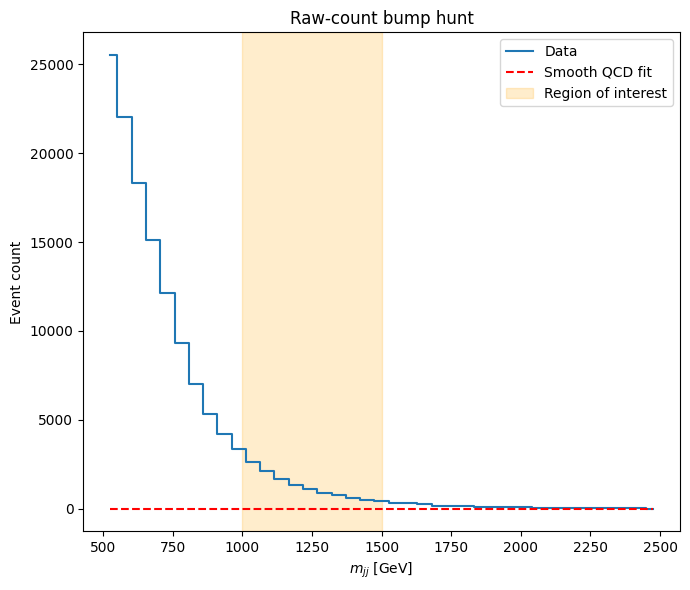

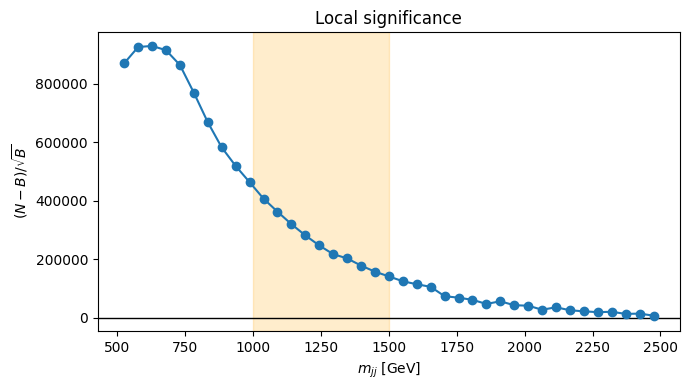

In [25]:
#!/usr/bin/env python3
# ============================================================
# Test 1: Raw-count bump hunt in mjj
# ============================================================

import uproot, awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_PERCENTILE = 99.9
MJJBINS = np.linspace(500, 2500, 40)

# ---------------- LOAD ----------------
scores = np.load(SCORES_FILE)

with uproot.open(ROOT_FILE) as f:
    mjj = ak.to_numpy(f[TREE]["mjj"].array())

assert len(mjj) == len(scores)

# ---------------- SELECT ANOMALIES ----------------
thr = np.percentile(scores, NSF_PERCENTILE)
is_anom = scores >= thr

mjj_all = mjj
mjj_anom = mjj[is_anom]

# ---------------- HISTOGRAM ----------------
counts, edges = np.histogram(mjj_all, bins=MJJBINS)
centers = 0.5 * (edges[1:] + edges[:-1])

# ---------------- BACKGROUND FIT ----------------
def qcd_shape(x, A, n):
    return A * np.power(x, -n)

mask_fit = (centers > 600) & (centers < 1800)
popt, _ = curve_fit(
    qcd_shape,
    centers[mask_fit],
    counts[mask_fit],
    p0=(1e9, 5),
    maxfev=10000
)

fit_vals = qcd_shape(centers, *popt)

# ---------------- SIGNIFICANCE ----------------
residual = (counts - fit_vals) / np.sqrt(fit_vals + 1e-6)

# ---------------- PLOT ----------------
plt.figure(figsize=(7,6))
plt.step(centers, counts, where="mid", label="Data")
plt.plot(centers, fit_vals, "r--", label="Smooth QCD fit")
plt.axvspan(1000, 1500, color="orange", alpha=0.2, label="Region of interest")

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Event count")
plt.legend()
plt.title("Raw-count bump hunt")
plt.tight_layout()
plt.show()

# ---------------- RESIDUAL ----------------
plt.figure(figsize=(7,4))
plt.axhline(0, color="k", lw=1)
plt.plot(centers, residual, "o-")
plt.axvspan(1000, 1500, color="orange", alpha=0.2)

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel(r"$(N - B)/\sqrt{B}$")
plt.title("Local significance")
plt.tight_layout()
plt.show()

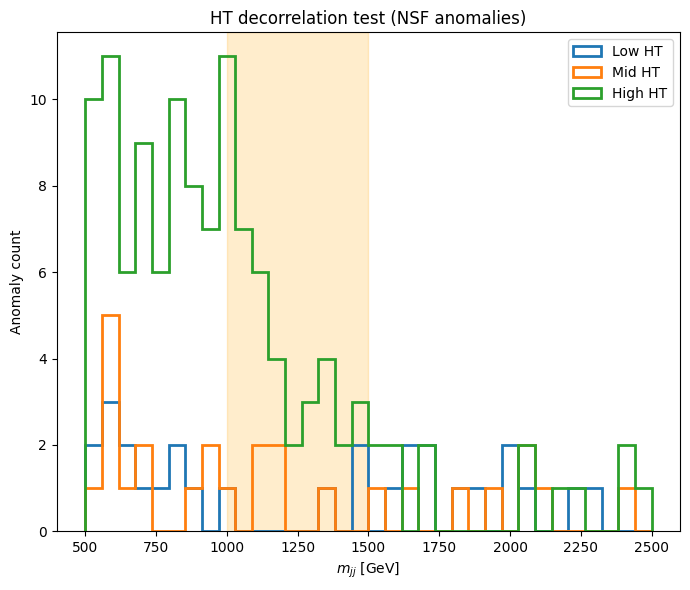

In [26]:
#!/usr/bin/env python3
# ============================================================
# Test 4: HT-decorrelation stress test
# ============================================================

import uproot, awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_PERCENTILE = 99.9
MJJBINS = np.linspace(500, 2500, 35)

# ---------------- LOAD ----------------
scores = np.load(SCORES_FILE)

with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays(["mjj", "HT"], library="ak")

mjj = ak.to_numpy(arrays["mjj"])
HT  = ak.to_numpy(arrays["HT"])

thr = np.percentile(scores, NSF_PERCENTILE)
is_anom = scores >= thr

# ---------------- HT SPLITS ----------------
ht_edges = np.percentile(HT, [0, 33, 66, 100])
labels = ["Low HT", "Mid HT", "High HT"]

plt.figure(figsize=(7,6))

for i in range(3):
    mask_ht = (HT >= ht_edges[i]) & (HT < ht_edges[i+1])
    mjj_sel = mjj[mask_ht & is_anom]

    plt.hist(
        mjj_sel,
        bins=MJJBINS,
        histtype="step",
        linewidth=2,
        label=labels[i]
    )

plt.axvspan(1000, 1500, color="orange", alpha=0.2)
plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Anomaly count")
plt.title("HT decorrelation test (NSF anomalies)")
plt.legend()
plt.tight_layout()
plt.show()

Anomalies selected: 379
HT [800,1100]  events: 80
HT [1100,1500] events: 128


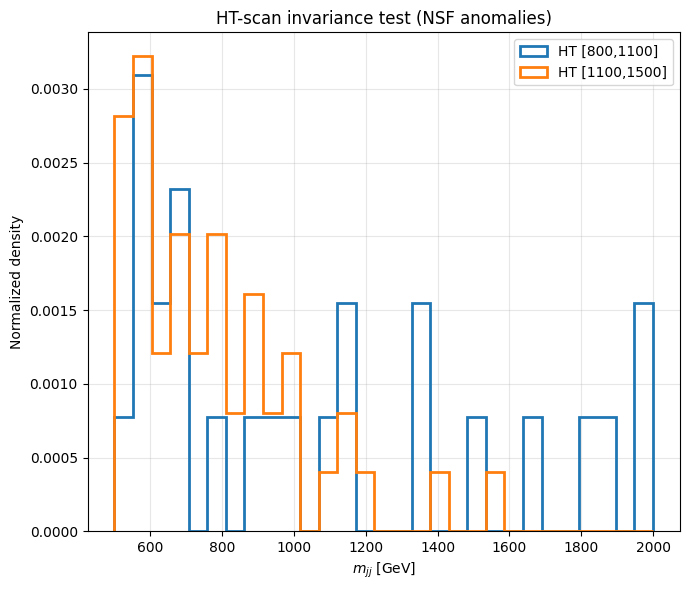

In [27]:
#!/usr/bin/env python3
# ============================================================
# Test: HT-scan invariance of mjj bump
# ============================================================

import uproot, awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# =======================
# USER INPUTS
# =======================

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_PERCENTILE = 99.9

# HT scan boundaries (adjust if needed)
HT_LOW  = 800
HT_MID  = 1100
HT_HIGH = 1500

MJJBINS = np.linspace(500, 2000, 30)

# =======================
# LOAD DATA
# =======================

scores = np.load(SCORES_FILE)

with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays(
        ["mjj", "HT"],
        library="ak"
    )

mjj = ak.to_numpy(arrays["mjj"])
HT  = ak.to_numpy(arrays["HT"])

assert len(scores) == len(mjj)

# =======================
# SELECT NSF ANOMALIES
# =======================

thr = np.percentile(scores, NSF_PERCENTILE)
anom = scores >= thr

print(f"Anomalies selected: {anom.sum()}")

# =======================
# HT SUB-BINS
# =======================

mask_A = anom & (HT > HT_LOW) & (HT <= HT_MID)
mask_B = anom & (HT > HT_MID) & (HT <= HT_HIGH)

print(f"HT [{HT_LOW},{HT_MID}]  events:", mask_A.sum())
print(f"HT [{HT_MID},{HT_HIGH}] events:", mask_B.sum())

# =======================
# PLOT
# =======================

plt.figure(figsize=(7,6))

plt.hist(
    mjj[mask_A],
    bins=MJJBINS,
    density=True,
    histtype="step",
    linewidth=2,
    label=f"HT [{HT_LOW},{HT_MID}]"
)

plt.hist(
    mjj[mask_B],
    bins=MJJBINS,
    density=True,
    histtype="step",
    linewidth=2,
    label=f"HT [{HT_MID},{HT_HIGH}]"
)

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Normalized density")
plt.title("HT-scan invariance test (NSF anomalies)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Permuting scores


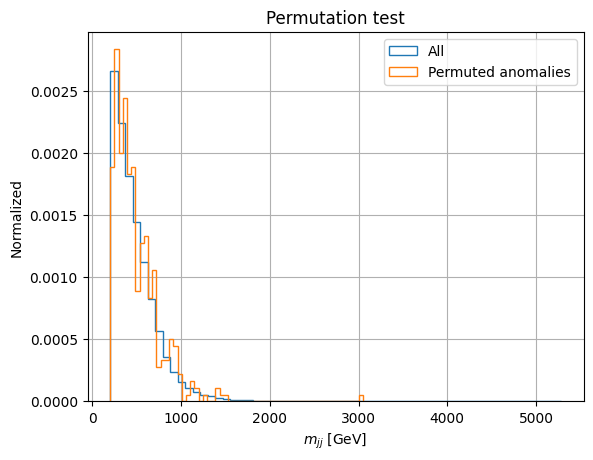

In [28]:
#!/usr/bin/env python3

import numpy as np
import uproot, awkward as ak
import matplotlib.pyplot as plt

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES = np.load("/kaggle/input/nsf-filterd/scores (1).npy")

print("Permuting scores")
perm_scores = np.random.permutation(SCORES)

threshold = np.percentile(perm_scores, 99.9)
mask = perm_scores >= threshold

tree = uproot.open(ROOT_FILE)[TREE]
mjj = ak.to_numpy(tree["mjj"].array())

plt.hist(mjj, bins=60, histtype="step", label="All", density=True)
plt.hist(mjj[mask], bins=60, histtype="step", label="Permuted anomalies", density=True)

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Normalized")
plt.legend()
plt.title("Permutation test")
plt.grid()
plt.show()

Real anomalies: 379
Permuted anomalies: 0


/usr/local/lib/python3.12/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


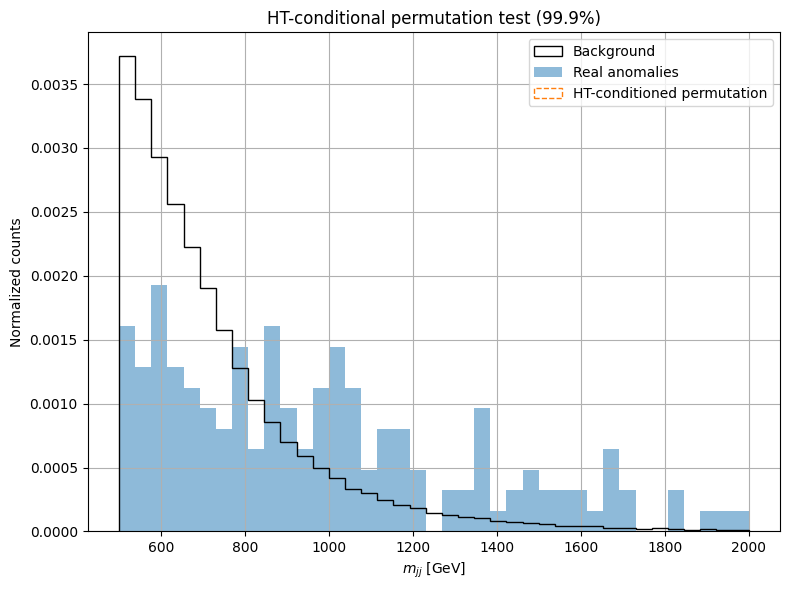

In [29]:
#!/usr/bin/env python3
# ============================================================
# HT-Conditional Permutation Test (EPJ-C grade)
# ============================================================

import uproot, awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# USER CONTROLS
# ==============================

NSF_PERCENTILE = 99.9
HT_BINS = [(500,800), (800,1100), (1100,1500), (1500,2000)]
MJJBINS = np.linspace(500, 2000, 40)

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

# ==============================
# LOAD DATA
# ==============================

scores = np.load(SCORES_FILE)

with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays(["mjj","HT"], library="ak")

df = pd.DataFrame({
    "mjj": ak.to_numpy(arrays["mjj"]),
    "HT":  ak.to_numpy(arrays["HT"]),
    "score": scores
})

assert len(df) == len(scores), "Mismatch!"

# ==============================
# CONDITIONAL PERMUTATION
# ==============================

df_perm = df.copy()
df_perm["score_perm"] = np.nan

for lo, hi in HT_BINS:
    mask = (df["HT"] >= lo) & (df["HT"] < hi)
    scores_bin = df.loc[mask, "score"].values
    np.random.shuffle(scores_bin)
    df_perm.loc[mask, "score_perm"] = scores_bin

# ==============================
# SELECT ANOMALIES
# ==============================

thr_real = np.percentile(df["score"], NSF_PERCENTILE)
thr_perm = np.percentile(df_perm["score_perm"], NSF_PERCENTILE)

anom_real = df[df["score"] >= thr_real]
anom_perm = df_perm[df_perm["score_perm"] >= thr_perm]

print("Real anomalies:", len(anom_real))
print("Permuted anomalies:", len(anom_perm))

# ==============================
# MJJ COMPARISON
# ==============================

plt.figure(figsize=(8,6))

plt.hist(
    df["mjj"], bins=MJJBINS,
    histtype="step", density=True,
    color="black", label="Background"
)

plt.hist(
    anom_real["mjj"], bins=MJJBINS,
    histtype="stepfilled", density=True,
    alpha=0.5, label="Real anomalies"
)

plt.hist(
    anom_perm["mjj"], bins=MJJBINS,
    histtype="step", density=True,
    linestyle="--", label="HT-conditioned permutation"
)

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Normalized counts")
plt.title(f"HT-conditional permutation test ({NSF_PERCENTILE}%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

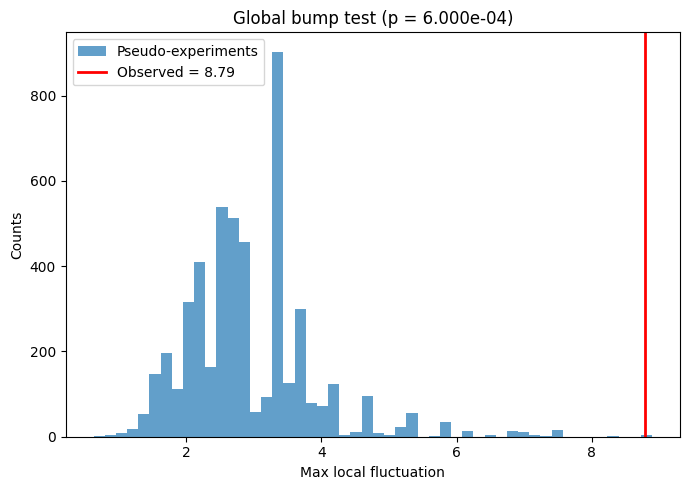

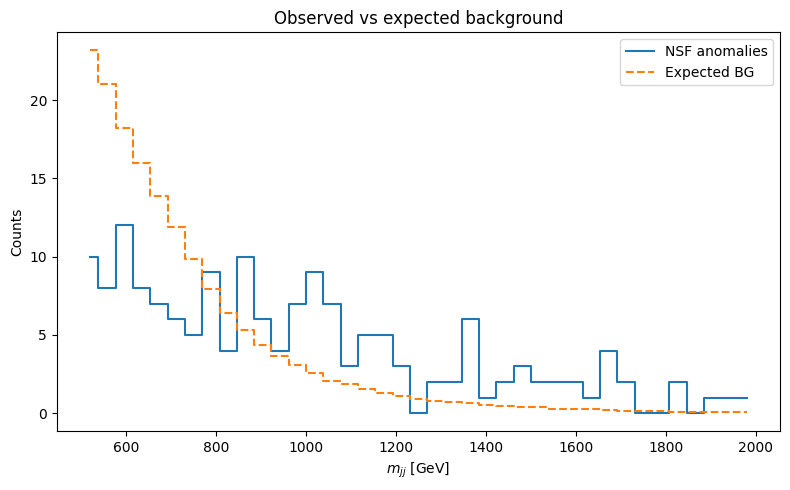

Observed max fluctuation: 8.79
Global p-value: 6.000e-04


In [30]:
#!/usr/bin/env python3
# ============================================================
# Test 2: Global bump-hunting with pseudo-experiments
# ============================================================

import uproot
import numpy as np
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_PERCENTILE = 99.9
BINS = np.linspace(500, 2000, 40)
N_PSEUDO = 5000

# ---------------- LOAD DATA ----------------
with uproot.open(ROOT_FILE) as f:
    mjj = f[TREE]["mjj"].array(library="np")

scores = np.load(SCORES_FILE)
threshold = np.percentile(scores, NSF_PERCENTILE)
anomaly_mask = scores >= threshold

mjj_anom = mjj[anomaly_mask]

# ---------------- HISTOGRAMS ----------------
hist_all, _ = np.histogram(mjj, bins=BINS)
hist_anom, _ = np.histogram(mjj_anom, bins=BINS)

# Normalize background to anomaly yield
scale = hist_anom.sum() / hist_all.sum()
expected_bg = hist_all * scale

# ---------------- PSEUDO-EXPERIMENTS ----------------
max_flucts = []

for _ in range(N_PSEUDO):
    pseudo = np.random.poisson(expected_bg)
    fluct = (pseudo - expected_bg) / np.sqrt(expected_bg + 1e-6)
    max_flucts.append(np.max(fluct))

max_flucts = np.array(max_flucts)

# ---------------- OBSERVED ----------------
obs_fluct = (hist_anom - expected_bg) / np.sqrt(expected_bg + 1e-6)
obs_max = np.max(obs_fluct)

p_value = np.mean(max_flucts >= obs_max)

# ---------------- PLOTS ----------------
centers = 0.5 * (BINS[:-1] + BINS[1:])

plt.figure(figsize=(7,5))
plt.hist(max_flucts, bins=50, alpha=0.7, label="Pseudo-experiments")
plt.axvline(obs_max, color="red", lw=2, label=f"Observed = {obs_max:.2f}")
plt.xlabel("Max local fluctuation")
plt.ylabel("Counts")
plt.title(f"Global bump test (p = {p_value:.3e})")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.step(centers, hist_anom, where="mid", label="NSF anomalies")
plt.step(centers, expected_bg, where="mid", label="Expected BG", linestyle="--")
plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Counts")
plt.title("Observed vs expected background")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Observed max fluctuation: {obs_max:.2f}")
print(f"Global p-value: {p_value:.3e}")

Total events: 378278
Anomalies selected: 379


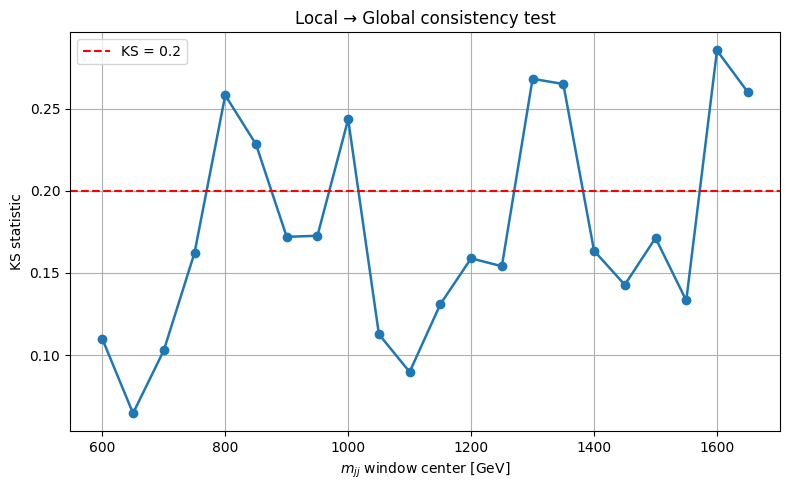

In [31]:
#!/usr/bin/env python3
# ============================================================
# Test 1: Local → Global shape consistency test
# ============================================================

import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"

NSF_PERCENTILE = 99.9
WINDOW_WIDTH = 200     # GeV
WINDOW_STEP  = 50      # GeV
MJj_MIN = 500
MJj_MAX = 2000

# ---------------- LOAD DATA ----------------
with uproot.open(ROOT_FILE) as f:
    mjj = f[TREE]["mjj"].array(library="np")

scores = np.load(SCORES_FILE)

threshold = np.percentile(scores, NSF_PERCENTILE)
anomaly_mask = scores >= threshold

mjj_anom = mjj[anomaly_mask]
mjj_all  = mjj

print(f"Total events: {len(mjj_all)}")
print(f"Anomalies selected: {len(mjj_anom)}")

# ---------------- SLIDING WINDOW KS ----------------
centers = []
ks_vals = []

for low in np.arange(MJj_MIN, MJj_MAX - WINDOW_WIDTH, WINDOW_STEP):
    high = low + WINDOW_WIDTH

    bg_slice = mjj_all[(mjj_all >= low) & (mjj_all < high)]
    an_slice = mjj_anom[(mjj_anom >= low) & (mjj_anom < high)]

    if len(an_slice) < 10 or len(bg_slice) < 50:
        continue

    ks = ks_2samp(an_slice, bg_slice).statistic
    centers.append(0.5 * (low + high))
    ks_vals.append(ks)

# ---------------- PLOT ----------------
plt.figure(figsize=(8,5))
plt.plot(centers, ks_vals, marker="o", lw=1.8)
plt.axhline(0.2, ls="--", c="red", label="KS = 0.2")
plt.xlabel(r"$m_{jj}$ window center [GeV]")
plt.ylabel("KS statistic")
plt.title("Local → Global consistency test")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🔹 Loading ROOT
🔹 Removing linear mjj dependence
🚀 Training mass-decorrelated NSF
Epoch 001 | NLL = 10.4488
Epoch 002 | NLL = -0.7395
Epoch 003 | NLL = -3.5701
Epoch 004 | NLL = -5.1746
Epoch 005 | NLL = -6.1445
Epoch 006 | NLL = -6.9204
Epoch 007 | NLL = -7.2764
Epoch 008 | NLL = -7.2794
Epoch 009 | NLL = -8.2354
Epoch 010 | NLL = -8.2725
Epoch 011 | NLL = -8.8349
Epoch 012 | NLL = -8.9371
Epoch 013 | NLL = -9.5479
Epoch 014 | NLL = -9.4989
Epoch 015 | NLL = -9.5045
Epoch 016 | NLL = -10.0306
Epoch 017 | NLL = -9.7963
Epoch 018 | NLL = -10.1336
Epoch 019 | NLL = -10.7064
Epoch 020 | NLL = -10.7044
Epoch 021 | NLL = -10.9600
Epoch 022 | NLL = -11.0478
Epoch 023 | NLL = -10.7497
Epoch 024 | NLL = -11.3256
Epoch 025 | NLL = -10.9285
Epoch 026 | NLL = -11.5505
Epoch 027 | NLL = -11.7597
Epoch 028 | NLL = -11.8600
Epoch 029 | NLL = -11.9454
Epoch 030 | NLL = -12.1374
Epoch 031 | NLL = -11.8082
Epoch 032 | NLL = -11.5957
Epoch 033 | NLL = -12.5317
Epoch 034 | NLL = -12.0049
Epoch 035 | NLL =

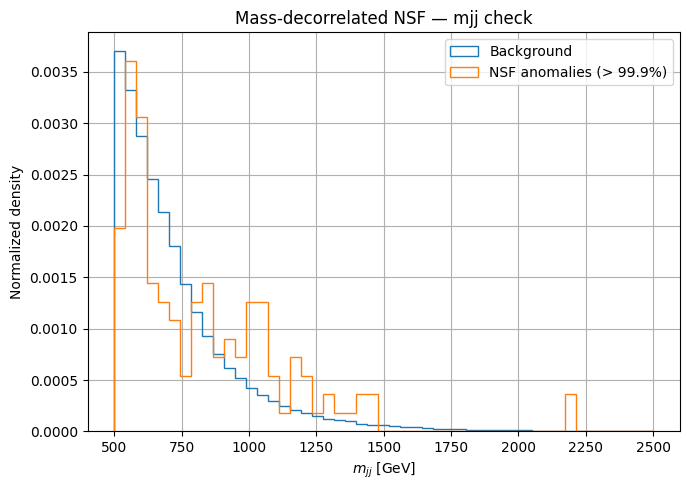

In [32]:
#!/usr/bin/env python3
# ============================================================
# Mass-decorrelated NSF retraining + mjj validation
# ============================================================

import uproot, awkward as ak
import numpy as np
import torch, joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, RandomPermutation,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform
)

# ---------------- CONFIG ----------------
ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"
OUTPUT_PREFIX = "nsf_mass_decorr"

NSF_PERCENTILE = 99.9
EPOCHS = 50
BATCH = 4096
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- FEATURES ----------------
FEATURES = [
    "j1_girth", "j1_tau1", "j1_tau2", "j1_tau3",
    "j1_tau21", "j1_tau32",
    "j1_ECF_ratio", "j1_width", "j1_mass",
    "HT", "sphericity"
]

MASS_VAR = "mjj"

# ---------------- LOAD DATA ----------------
print("🔹 Loading ROOT")
with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays(FEATURES + [MASS_VAR], library="ak")

X = np.column_stack([ak.to_numpy(arrays[f]) for f in FEATURES])
mjj = ak.to_numpy(arrays[MASS_VAR])

# ---------------- MASS DECORRELATION ----------------
print("🔹 Removing linear mjj dependence")
X_decorr = X.copy()

for i in range(X.shape[1]):
    coef = np.polyfit(mjj, X[:, i], deg=1)
    X_decorr[:, i] -= coef[0] * mjj

# ---------------- SCALE ----------------
scaler = StandardScaler()
X_decorr = scaler.fit_transform(X_decorr)
joblib.dump(scaler, f"{OUTPUT_PREFIX}_scaler.pkl")

# ---------------- NSF MODEL ----------------
def build_nsf(dim):
    transforms = []
    for _ in range(6):
        transforms += [
            RandomPermutation(dim),
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=dim,
                hidden_features=128,
                num_bins=8,
                tails="linear",
                tail_bound=5.0
            )
        ]
    return Flow(CompositeTransform(transforms), StandardNormal([dim]))

flow = build_nsf(X_decorr.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(flow.parameters(), lr=LR)

dataset = TensorDataset(torch.tensor(X_decorr, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=BATCH, shuffle=True, drop_last=True)

# ---------------- TRAIN ----------------
print("🚀 Training mass-decorrelated NSF")
for e in range(1, EPOCHS + 1):
    losses = []
    for (x,) in loader:
        x = x.to(DEVICE)
        loss = -flow.log_prob(x).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {e:03d} | NLL = {np.mean(losses):.4f}")

torch.save(flow.state_dict(), f"{OUTPUT_PREFIX}_weights.pt")

# ---------------- SCORE EVENTS ----------------
print("🔍 Scoring events")
flow.eval()
with torch.no_grad():
    scores = -flow.log_prob(
        torch.tensor(X_decorr, dtype=torch.float32).to(DEVICE)
    ).cpu().numpy()

np.save(f"{OUTPUT_PREFIX}_scores.npy", scores)

# ---------------- SELECT ANOMALIES ----------------
threshold = np.percentile(scores, NSF_PERCENTILE)
anom_mask = scores >= threshold

print(f"✅ Anomalies selected: {anom_mask.sum()}")

# ---------------- PLOT mjj ----------------
bins = np.linspace(500, 2500, 50)

plt.figure(figsize=(7,5))
plt.hist(
    mjj[~anom_mask], bins=bins, density=True,
    histtype="step", lw=2, label="Background"
)
plt.hist(
    mjj[anom_mask], bins=bins, density=True,
    histtype="step", lw=2, label=f"NSF anomalies (> {NSF_PERCENTILE}%)"
)

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Normalized density")
plt.title("Mass-decorrelated NSF — mjj check")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔹 Loading NSF scores (.npy)
🔹 Loading ROOT features
Total events      : 378278
Anomalies selected: 379


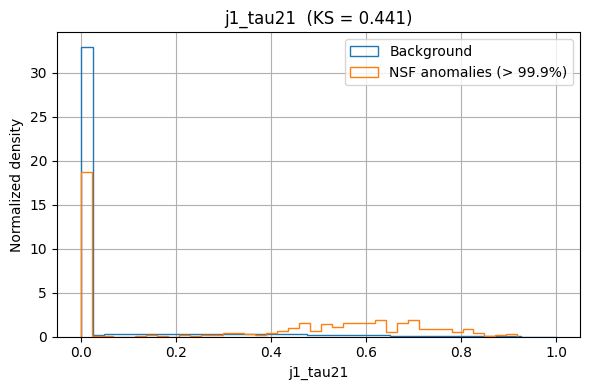

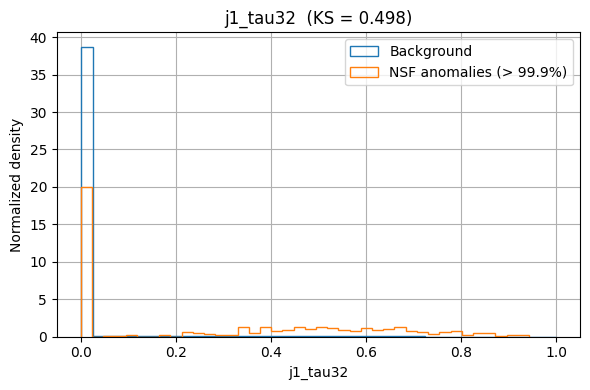

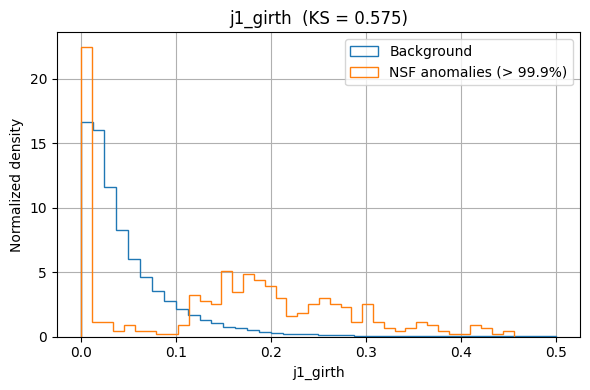

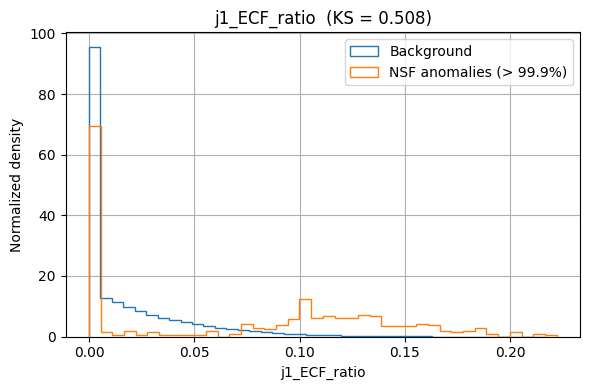

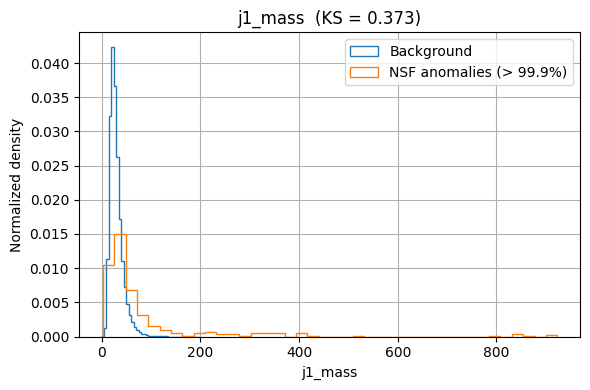

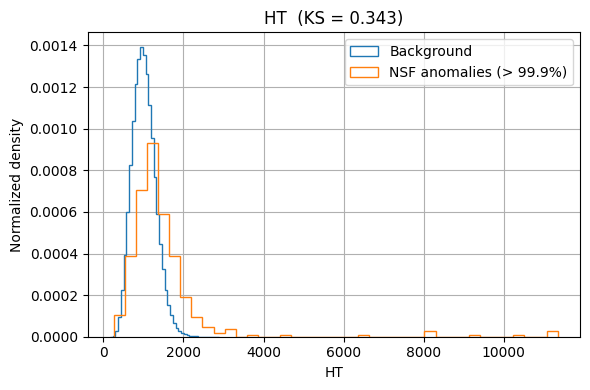


🔍 Feature ranking by KS separation:
j1_girth        : KS = 0.575
j1_ECF_ratio    : KS = 0.508
j1_tau32        : KS = 0.498
j1_tau21        : KS = 0.441
j1_mass         : KS = 0.373
HT              : KS = 0.343


In [33]:
#!/usr/bin/env python3
# ============================================================
# Feature-wise KS test using NSF scores (.npy)
# ============================================================

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# =========================
# CONFIG
# =========================

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"

SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"   # <-- NSF scores (.npy)
ANOMALY_Q = 99.9

BINS = 40

FEATURES = [
    "j1_tau21",
    "j1_tau32",
    "j1_girth",
    "j1_ECF_ratio",
    "j1_mass",
    "HT",
]

# =========================
# LOAD DATA
# =========================

print("🔹 Loading NSF scores (.npy)")
scores = np.load(SCORES_FILE)

print("🔹 Loading ROOT features")
with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays(FEATURES, library="ak")

data = {k: ak.to_numpy(arrays[k]) for k in FEATURES}

# Safety check
n_events = len(scores)
for f in FEATURES:
    assert len(data[f]) == n_events, f"Mismatch in {f}"

# =========================
# DEFINE ANOMALIES
# =========================

threshold = np.percentile(scores, ANOMALY_Q)
mask_anom = scores >= threshold
mask_bg   = scores < threshold

print(f"Total events      : {n_events}")
print(f"Anomalies selected: {mask_anom.sum()}")

# =========================
# KS TEST + PLOTS
# =========================

ks_results = {}

for feat in FEATURES:
    x_bg   = data[feat][mask_bg]
    x_anom = data[feat][mask_anom]

    # Clean
    x_bg   = x_bg[np.isfinite(x_bg)]
    x_anom = x_anom[np.isfinite(x_anom)]

    # KS
    ks = ks_2samp(x_bg, x_anom).statistic
    ks_results[feat] = ks

    # Plot
    plt.figure(figsize=(6,4))
    plt.hist(
        x_bg, bins=BINS, density=True,
        histtype="step", lw=2, label="Background"
    )
    plt.hist(
        x_anom, bins=BINS, density=True,
        histtype="step", lw=2, label=f"NSF anomalies (> {ANOMALY_Q}%)"
    )

    plt.xlabel(feat)
    plt.ylabel("Normalized density")
    plt.title(f"{feat}  (KS = {ks:.3f})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =========================
# RANKING
# =========================

print("\n🔍 Feature ranking by KS separation:")
for feat, ks in sorted(ks_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{feat:15s} : KS = {ks:.3f}")

🔹 Loading NSF scores
🔹 Loading ROOT features


Reading ROOT branches: 100%|██████████| 2/2 [00:00<00:00, 38.08it/s]


Total events      : 378278
Anomalies selected: 379
🔹 Standardizing features
🔹 Computing background density grid
🔹 Plotting


Plotting steps: 100%|██████████| 2/2 [00:00<00:00, 131.77it/s]


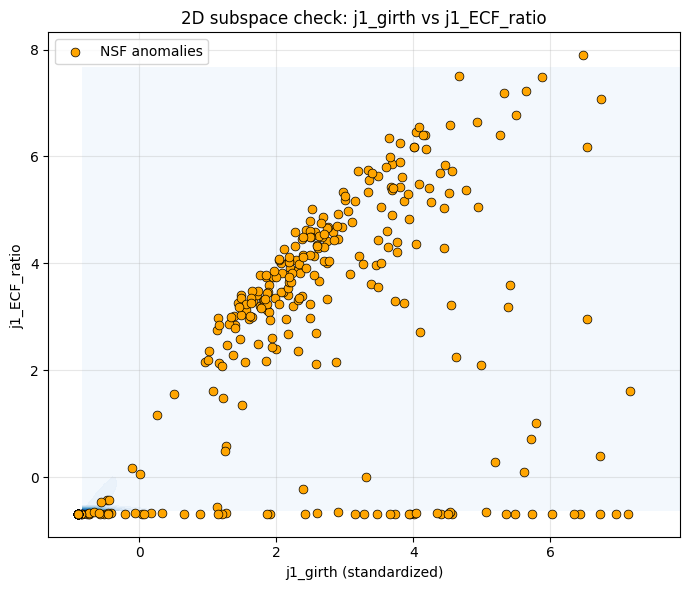

In [34]:
#!/usr/bin/env python3
# ============================================================
# Final 2D subspace check: j1_girth vs j1_tau21
# Background density contours + NSF anomalies
# (Grid-based contours: SAFE replacement for tricontourf)
# ============================================================

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# =========================
# CONFIG
# =========================

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"

SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"   # <-- NSF scores (.npy)NSF_PERCENTILE = 99.9

FEATURES = ["j1_girth", "j1_ECF_ratio"]

# Grid resolution for contours
NBINS = 80

# =========================
# LOAD DATA
# =========================
print("🔹 Loading NSF scores")
scores = np.load(SCORES_FILE)

print("🔹 Loading ROOT features")
with tqdm(total=len(FEATURES), desc="Reading ROOT branches") as pbar:
    with uproot.open(ROOT_FILE) as f:
        arrays = {}
        for feat in FEATURES:
            arrays[feat] = f[TREE][feat].array(library="ak")
            pbar.update(1)

X = np.column_stack([ak.to_numpy(arrays[f]) for f in FEATURES])

# =========================
# BASIC SANITY
# =========================
assert len(X) == len(scores), "❌ ROOT / score length mismatch"

finite_mask = np.all(np.isfinite(X), axis=1)
X = X[finite_mask]
scores = scores[finite_mask]

# =========================
# SELECT ANOMALIES
# =========================
threshold = np.percentile(scores, NSF_PERCENTILE)
mask_anom = scores >= threshold
mask_bg   = scores < threshold

print(f"Total events      : {len(scores)}")
print(f"Anomalies selected: {mask_anom.sum()}")

# =========================
# STANDARDIZE (for geometry only)
# =========================
print("🔹 Standardizing features")
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_bg   = X_std[mask_bg]
X_anom = X_std[mask_anom]

# =========================
# BUILD GRID FOR CONTOURS (FAST)
# =========================
print("🔹 Computing background density grid")

x = X_bg[:,0]
y = X_bg[:,1]

H, xedges, yedges = np.histogram2d(
    x, y,
    bins=NBINS,
    density=True
)

# Grid centers
Xc = 0.5 * (xedges[:-1] + xedges[1:])
Yc = 0.5 * (yedges[:-1] + yedges[1:])
Xg, Yg = np.meshgrid(Xc, Yc)

# =========================
# PLOTTING (SAME LOOK, NO FREEZE)
# =========================
print("🔹 Plotting")
plt.figure(figsize=(7,6))

with tqdm(total=2, desc="Plotting steps") as pbar:
    # Background density contours (FILLED, SAME STYLE)
    plt.contourf(
        Xg, Yg, H.T,
        levels=18,
        cmap="Blues",
        alpha=0.85
    )
    pbar.update(1)

    # NSF anomalies (unchanged)
    plt.scatter(
        X_anom[:,0], X_anom[:,1],
        c="orange",
        s=40,
        edgecolor="k",
        linewidth=0.5,
        label="NSF anomalies",
        zorder=3
    )
    pbar.update(1)

plt.xlabel("j1_girth (standardized)")
plt.ylabel("j1_ECF_ratio ")
plt.title("2D subspace check: j1_girth vs j1_ECF_ratio")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

🔹 Loading NSF scores
🔹 Loading ROOT features
Total events      : 378278
Anomalies selected: 379


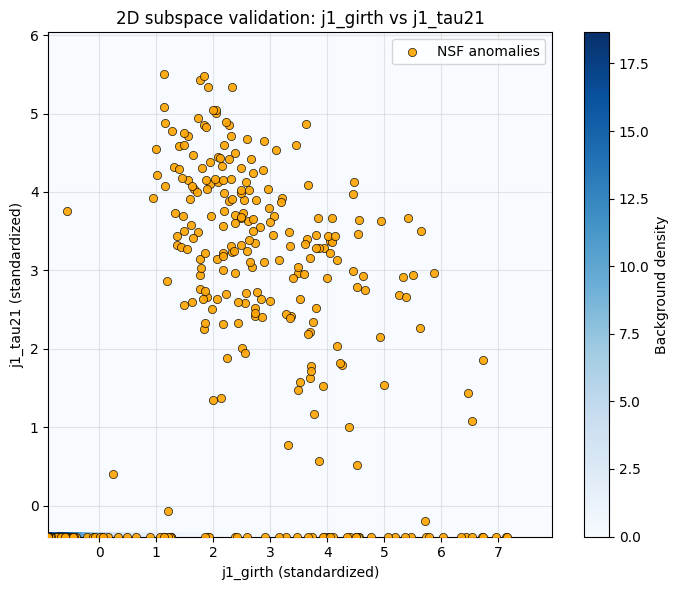

In [35]:
#!/usr/bin/env python3
# ============================================================
# Final 2D subspace check (SAFE VERSION)
# j1_girth vs j1_tau21
# Background density (hist2d) + NSF anomalies
# ============================================================

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# =========================
# CONFIG
# =========================

ROOT_FILE = "/kaggle/input/preprocessed/final_merged_features_clean.root"
TREE = "Events"

SCORES_FILE = "/kaggle/input/nsf-filterd/scores (1).npy"   # <-- NSF scores (.npy)
NSF_PERCENTILE = 99.9

FEATURES = ["j1_girth", "j1_tau21"]

BINS = 120   # background resolution

# =========================
# LOAD DATA
# =========================
print("🔹 Loading NSF scores")
scores = np.load(SCORES_FILE)

print("🔹 Loading ROOT features")
with uproot.open(ROOT_FILE) as f:
    arrays = f[TREE].arrays(FEATURES, library="ak")

X = np.column_stack([ak.to_numpy(arrays[f]) for f in FEATURES])

# =========================
# SANITY
# =========================
finite = np.all(np.isfinite(X), axis=1)
X = X[finite]
scores = scores[finite]

assert len(X) == len(scores)

# =========================
# SELECT ANOMALIES
# =========================
thr = np.percentile(scores, NSF_PERCENTILE)
mask_anom = scores >= thr
mask_bg   = scores < thr

print(f"Total events      : {len(scores)}")
print(f"Anomalies selected: {mask_anom.sum()}")

# =========================
# STANDARDIZE (geometry only)
# =========================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

bg   = X_std[mask_bg]
anom = X_std[mask_anom]

# =========================
# 2D BACKGROUND DENSITY
# =========================
plt.figure(figsize=(7,6))

h = plt.hist2d(
    bg[:,0], bg[:,1],
    bins=BINS,
    density=True,
    cmap="Blues"
)

plt.colorbar(label="Background density")

# =========================
# NSF ANOMALIES OVERLAY
# =========================
plt.scatter(
    anom[:,0], anom[:,1],
    s=35,
    c="orange",
    edgecolor="k",
    linewidth=0.5,
    alpha=0.9,
    label="NSF anomalies",
    zorder=3
)

plt.xlabel("j1_girth (standardized)")
plt.ylabel("j1_tau21 (standardized)")
plt.title("2D subspace validation: j1_girth vs j1_tau21")

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()